# Image Classification Challenge

In [1]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

##################################################
# Set current directory
##################################################

currentDirectory=os.getcwd()#current working directory

DATA_BASE_FOLDER = 'data'

# Dataset

The dataset contains 50k train + 10k validation images of 10 different categories ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot').

Each image is a 28x28 grayscale, and for simplicity here is flattened into a 784 dimensional vector.

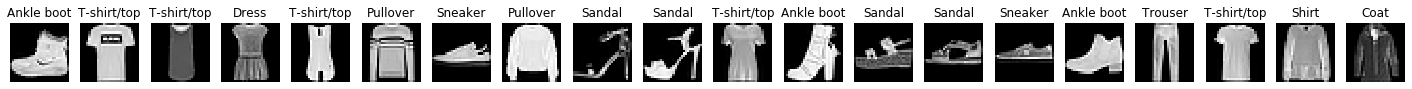

In [2]:
##################################################
# Load dataset
##################################################

x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

In [3]:
x_train.shape

(50000, 784)

# Overview

We are going to apply four different models:
- Logistic Regression
- KNN
- Random Forest
- Support Vector Machines
- Convolutional Neural Networks

For each of them we apply the needed pre-processing of data and evaluate their performances.

# Model - Logistic Regression

### Pre-processing
Since we are going to apply regularization, it's advisible to rescale the data. 

In [4]:
x_train_scaled=x_train/255
x_valid_scaled=x_valid/255
x_test_scaled=x_test/255

In order to fit the data in a reasonable amount of time, we take 20% of observations in the train set to fit the model.

Since classes are almost balanced, we just take the first 10000 observations.

In [5]:
x_train_reduced=x_train_scaled[0:10000]
y_train_reduced=y_train[0:10000]

### Model estimation

In [6]:
from sklearn.linear_model import LogisticRegression

In order to maximize the performance of the model, we have to find the optimal values for the hyperparameters:
- penalty: $l_1$ (Lasso) or $l_2$ (Ridge) 
- C: the inverse of regularization hyperparameter $\lambda$, so $C=\frac{1}{\lambda}$
- solver: we choose the only two algorithms which support both penalties

This can be done using the **grid search** technique.

First define the grid over which the search has to be performed:

In [7]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear', 'saga']
param_grid = dict(penalty=penalty,
                  C=C,
                  solver=solver)

Define the Cross Validation (CV) strategy: 
- compute the frequency of each class
- shuffle the training set
- split it in 5 folds respecting the frequency of each class within each fold
- set a random seed for replicability

In [9]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

We define the model and fit the grid search:

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
logreg = LogisticRegression()

grid_search_logistic = GridSearchCV(estimator=logreg,
                                    param_grid=param_grid,
                                    cv=cv,
                                    n_jobs=-1)
grid_search_logistic.fit(x_train_reduced, y_train_reduced)

print(grid_search_logistic.best_params_)
print("Cross Validation Accuracy: %f" % grid_search_logistic.best_score_)

In [37]:
#load the grid search
grid_search_logistic = joblib.load('data/grid_search_Logistic.sav')

The results of the grid search are:

In [38]:
results_grid_search_logistic = pd.DataFrame(grid_search_logistic.cv_results_)
results_grid_search_logistic=results_grid_search_logistic[['params','mean_test_score','rank_test_score']]
results_grid_search_logistic.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_logistic.head()

,params,mean_test_score,rank_test_score
15,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",0.8430,1
17,"{'C': 1, 'penalty': 'l1', 'solver': 'saga'}",0.8405,2
14,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.8403,3
16,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.8365,4
19,"{'C': 1, 'penalty': 'l2', 'solver': 'saga'}",0.8363,5


### Train the model with the optimal hyperparameters on the full Training Set
We train the model with optimal hyperparameters found in the reduced training set, on the full train set.

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [32]:
logreg = LogisticRegression(penalty='l2',
                            C=0.1,
                            solver='saga',
                            max_iter=1000)
logreg.fit(x_train_scaled,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# to load the model from disk
logreg = joblib.load('data/LogisticRegr.sav')

### Model evaluation

In [34]:
logreg.score(x_valid_scaled, y_valid)

0.8559

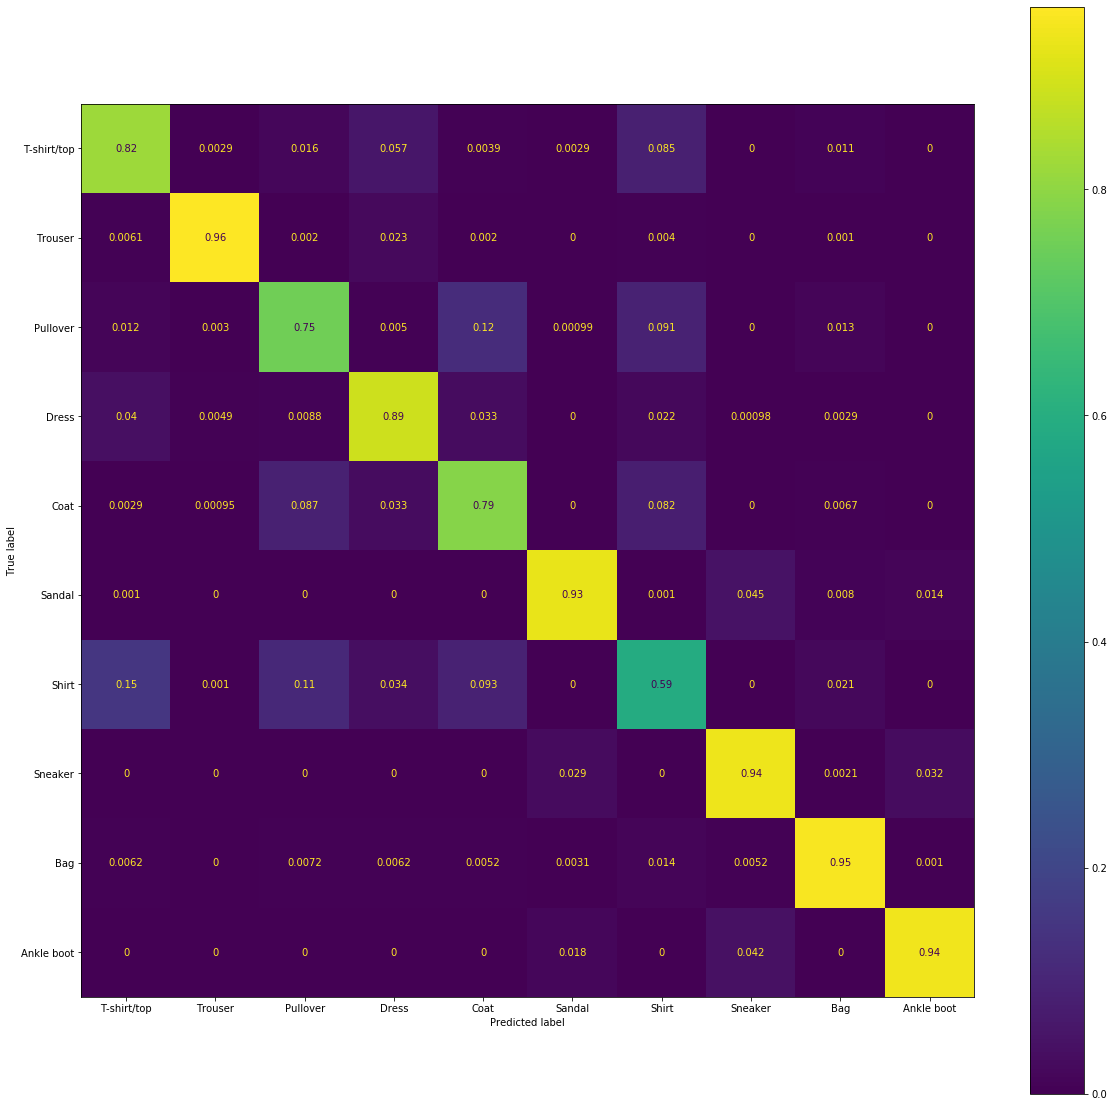

In [36]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(logreg, x_valid_scaled, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown label in the test set: 

In [39]:
y_pred_logreg=logreg.predict(x_test_scaled)

In [44]:
# save that on a .csv file for the submission
predictions_logreg_file=pd.DataFrame(y_pred_logreg)
predictions_logreg_file = predictions_logreg_file.to_csv('data/y_predictions_logreg.csv', sep=',',index=False)

# Model - KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

### Pre-processing
For better numerical stability is advisible to divide by 255 each feature.


In [46]:
x_train_scaled=x_train/255
x_valid_scaled=x_valid/255
x_test_scaled=x_test/255

### Model estimation
We use grid search to find the best value of k (='n_neighbors'). 

We do not look for the best value of $p$ in the $L_p$ metrics, because theorical 
results have prooved that the meaningfulness of the $L_p$ norm worsens faster within 
increasing dimensionality for higher values of $p$. Thus, for a given problem with a 
fixed (high) value for the dimensionality $d$, it is preferable to use lower values of $p$.
This means that the $L_1$ distance metric (Manhattan distance metric) is the most preferable 
for high dimensional applications, followed by the Euclidean metric ($L_2$).  
For reference see:

- Charu C. Aggarwal, Alexander Hinneburg, Daniel A. Keim, "On the Surprising Behavior of    Distance Metrics in High Dimensional Space"
- Kevin Beyer, Jonathan Goldstein, Raghu Ramakrishnan, Uri Shaft, "When Is 'Nearest Neighbor' Meaningful?"

In order to maximize the performance of the model, we have to find the optimal values for the hyperparameter:
- n_neighbors: the number of observations defining the neighborhood of the target observation 

This can be done using the **grid search** technique.

First define the grid over which the search has to be performed:

In [47]:
# Define the grid for the grid search
param_grid = {'n_neighbors': list(range(1,21))}
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}


Define the Cross Validation (CV) strategy: 
- compute the frequency of each class
- shuffle the training set
- split it in 5 folds respecting the frequency of each class within each fold
- set a random seed for replicability

In [49]:
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

We define the model and fit the grid search:

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
# grid search with 5 fold cross validation
grid_search_knn = GridSearchCV(KNeighborsClassifier(p=1),
                           param_grid, 
                           cv=cv,
                           n_jobs=-1)
grid_search_knn.fit(x_train_scaled, y_train)
print(grid_search_knn.best_params_)
print("Cross Validation Accuracy: %f" % grid_search_knn.best_score_)

The size of the full output file (.sav) is too big to be sent or uploaded, so we converted it in a Dataframe and then we saved it as a .csv file: 

In [57]:
#load the grid search results:
results_grid_search_knn=pd.read_csv('data/results_grid_search_knn.csv')
results_grid_search_knn.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_knn.head()

,params,mean_test_score,rank_test_score
4,{'n_neighbors': 5},0.85958,1
5,{'n_neighbors': 6},0.85946,2
3,{'n_neighbors': 4},0.85858,3
7,{'n_neighbors': 8},0.85838,4
6,{'n_neighbors': 7},0.85820,5


### Train the model with the optimal hyperparameters on the full Training Set
We train the model with optimal hyperparameters in the full training set.

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [132]:
knn_5 =KNeighborsClassifier(n_neighbors=5, p=1)
knn_5.fit(x_train_scaled,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')

### Model evaluation

In [133]:
# to load the score in the validation set from disk
#knn_5_score = pd.read_csv('data/5nn_score.csv')
#knn_5_score

# Use this function to evaluate your model
y_pred=knn_5.predict(x_valid_scaled)
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.
valid_set_accuracy=accuracy(y_pred,y_valid)
valid_set_accuracy

0.857

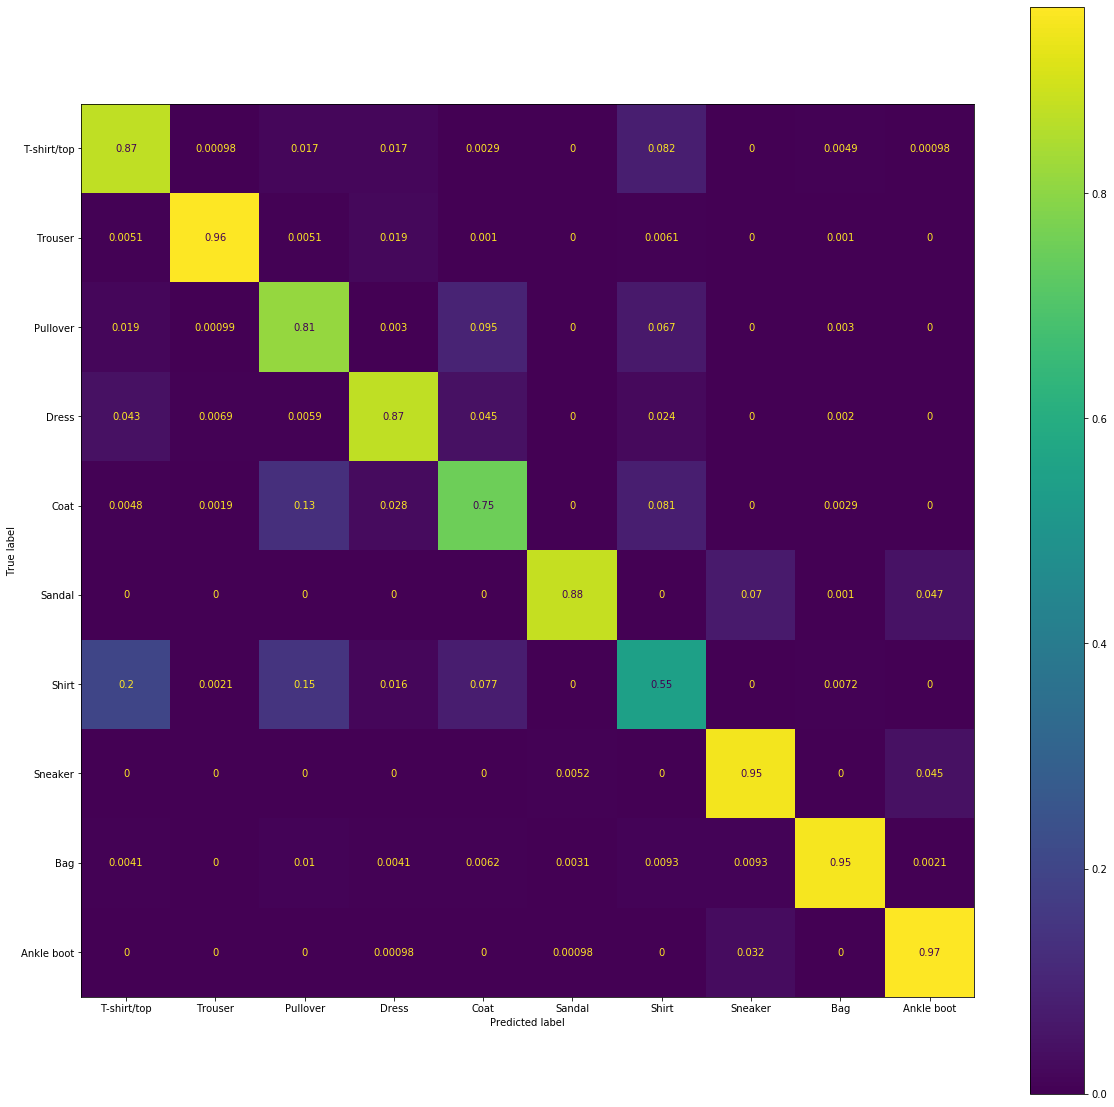

In [134]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(knn_5, x_valid_scaled, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

## Test with Euclidean Distance
To check if the Manhattan metric yields better results than the Euclidean we make the same grid search using the $L_2$ metric. 

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
# STRATIFIED KFOLD + GRID SEARCH (EUCLIDEAN METRIC (L2))
# use grid search to find the best value of k

# with p=2 we are using the euclidean Distance (default parameter)
grid_search_euclidean = GridSearchCV(
                                        KNeighborsClassifier(p=2), 
                                        param_grid, 
                                        cv=cv, 
                                        n_jobs=-1)
grid_search_euclidean.fit(x_train_norm, y_train)

The size of the full output file (.sav) is too big to be sent or uploaded, so we converted it in a Dataframe and then we saved it as a .csv file: 

In [85]:
#load the grid search results:
results_grid_search_knn=pd.read_csv('data/results_grid_search_euclidean.csv')
results_grid_search_knn.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_knn.head()

,params,mean_test_score,rank_test_score
5,{'n_neighbors': 6},0.85258,1
3,{'n_neighbors': 4},0.85246,2
4,{'n_neighbors': 5},0.85200,3
7,{'n_neighbors': 8},0.85170,4
6,{'n_neighbors': 7},0.85098,5


### Train the model with the optimal hyperparameters on the full Training Set
We train the model with optimal hyperparameters in the full training set.

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [87]:
knn_6 =KNeighborsClassifier(n_neighbors=6, p=2)
knn_6.fit(x_train_scaled,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

### Model evaluation

In [135]:
# to load the score in the validation set from disk
#knn_6_score = pd.read_csv('data/6nn_score.csv')
#knn_6_score
# Use this function to evaluate your model
y_pred=knn_6.predict(x_valid_scaled)
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.
valid_set_accuracy=accuracy(y_pred,y_valid)
valid_set_accuracy

0.8547

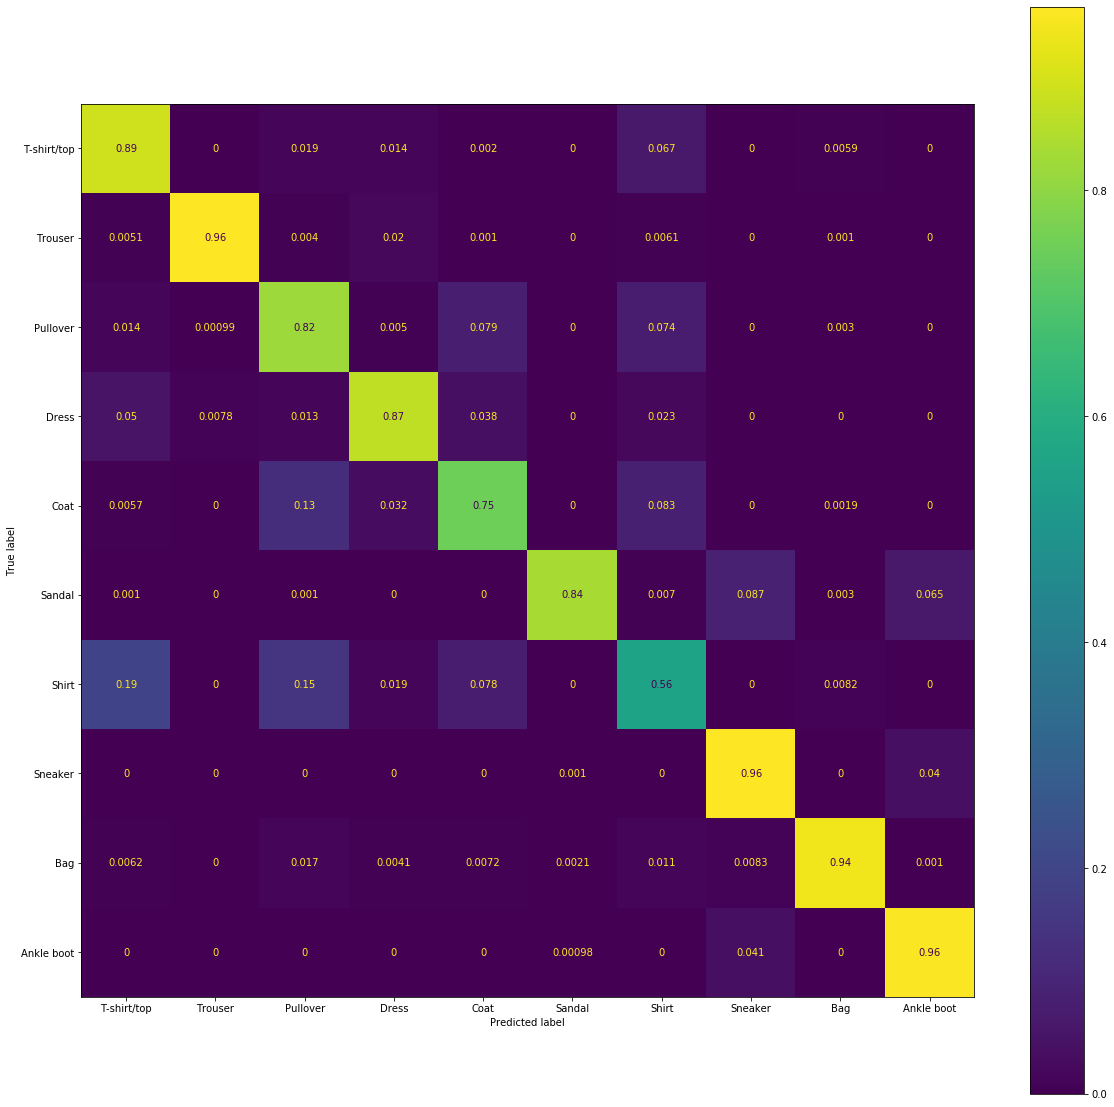

In [136]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(knn_6, x_valid_scaled, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

The empirical check has shown the validity of the theoretical result stated and the beginning: 

the best metric is $L_1$

Hence in the following we proceed in our analysis using the mode **knn_5**.

### Dimensionaly reduction using PCA
To recognize an item, we don't look at the single pixel, but at the overall image.
So extracting Principal Components (PCs) and using them to identify different items 
is an attempt to mimic how humans identify items.
Using the optimal value of $k$ found before, we look how much varies the accuracy
in train and valid set increasing the n° of PCs used to approximate each sample.
Around 20 PCs, the Accuracy curve starts being flat, meaning that adding further 
PCs increases just a little the performance, so it's not worth to add them.

In [92]:
from sklearn.decomposition import PCA

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE SAVED IMAGE**) 

In [ ]:
test_accuracy = []
PC_number = range(1, 101)
for i in PC_number:
    pca = PCA(n_components=i, whiten=True, random_state=0).fit(x_train)
    x_train_pca = pca.transform(x_train)
    x_valid_pca = pca.transform(x_valid)
    knn = KNeighborsClassifier(n_neighbors=k_star,p=1)
    knn.fit(x_train_pca, y_train)
    # record generalization accuracy
    test_accuracy.append(knn.score(x_valid_pca, y_valid.reshape(-1,1)))

plt.plot(PC_number, test_accuracy, label="valid accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n° PC")
plt.legend()  

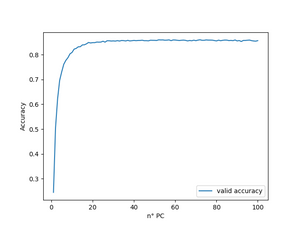

In [95]:
#load the figure
import matplotlib.image as mpimg
img = mpimg.imread('data/Accuracy VS number_PCs.png')
plt.axis('off')
plt.imshow(img,interpolation='spline36')

We now try a similar approach, but at each iteration we perform a grid search in order to be sure that the best parameter is chosen at every step. Since it's a really long process, we make this experiment just on 20000 samples and not all the TS

In [33]:
#SET SIZE = size of training set to use. Use 50000 to use full TS
size = 20000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:size]/255
x_test_sc =x_test/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:size]

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE SAVED IMAGE**) 

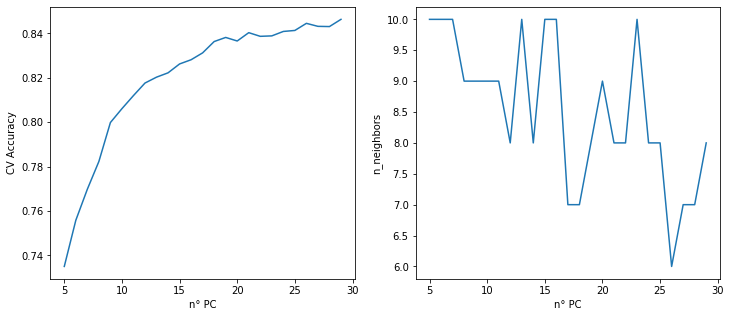

In [38]:
# WE PLOT the cv accuracy of KNN (for every model we perform grid search for the best parameter)
# w.r.t. the number of principal components

#training_accuracy = []
cv_accuracy = []
best_params= []
PC_number = range(5, 30)

#build a single big PCA
pca = PCA(n_components=50, whiten=True, random_state=0).fit(x_train_sc)
x_train_pca = pca.transform(x_train_sc)
x_valid_pca = pca.transform(x_valid_sc)

for i in PC_number:
    x_train_pca_aux = x_train_pca[:, :i]
    x_valid_pca_aux = x_valid_pca[:, :i]
    grid_search_aux = GridSearchCV(KNeighborsClassifier(p=1), param_grid, cv=cv, n_jobs=-1)
    grid_search_aux.fit(x_train_pca_aux, y_train_sc)
    
    # record generalization accuracy
    cv_accuracy.append(grid_search_aux.best_score_)
    best_params.append(grid_search_aux.best_params_["n_neighbors"])

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].set_ylabel("CV Accuracy")
axes[0].set_xlabel("n° PC")

axes[1].set_ylabel("n_neighbors")
axes[1].set_xlabel("n° PC")

_ = axes[0].plot(PC_number, cv_accuracy, label="valid accuracy")
_ = axes[1].plot(PC_number, best_params)


In [ ]:
#load the figure
import matplotlib.image as mpimg
img = mpimg.imread('data/img pc.png')
plt.axis('off')
plt.imshow(img,interpolation='spline36')

So as we can see we don't obtain much better results in terms of cv accuracy.

Observing the plots, the accuracy growth becomes flat approx. after the first 20 PCs. 
So to have an easier model, with less features, we decide to use 20 PCs.

In [33]:
PCs_star=20

We compute the first 20 PCs for train set and validation set.

In [97]:
pca = PCA(n_components=20, whiten=True, random_state=0).fit(x_train_scaled)
x_train_pca = pca.transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

We train the model with the optimal hyperparameter $k^*=5$ on the full training set.

In [98]:
knn_5_pca = KNeighborsClassifier(n_neighbors=5,p=1)
knn_5_pca.fit(x_train_pca, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE SAVED IMAGE**) 

In [ ]:
#plot the PCs
print("pca.components_.shape: {}".format(pca.components_.shape))
fix, axes = plt.subplots(4, 5, figsize=(15, 12),subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape((28,28)),cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))
plt.savefig('first 20 PCs.png')

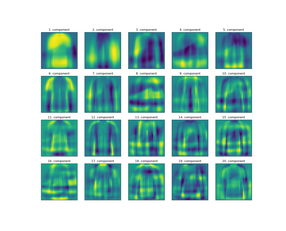

In [41]:
#load the figure
img = mpimg.imread('data/first 20 PCs.png')
plt.axis('off')
plt.imshow(img,interpolation='spline36')

### Model evaluation

The perfomance in the validation set is:

In [103]:
knn_5_pca.score(x_valid_pca, y_valid.reshape(-1,1))

0.8482

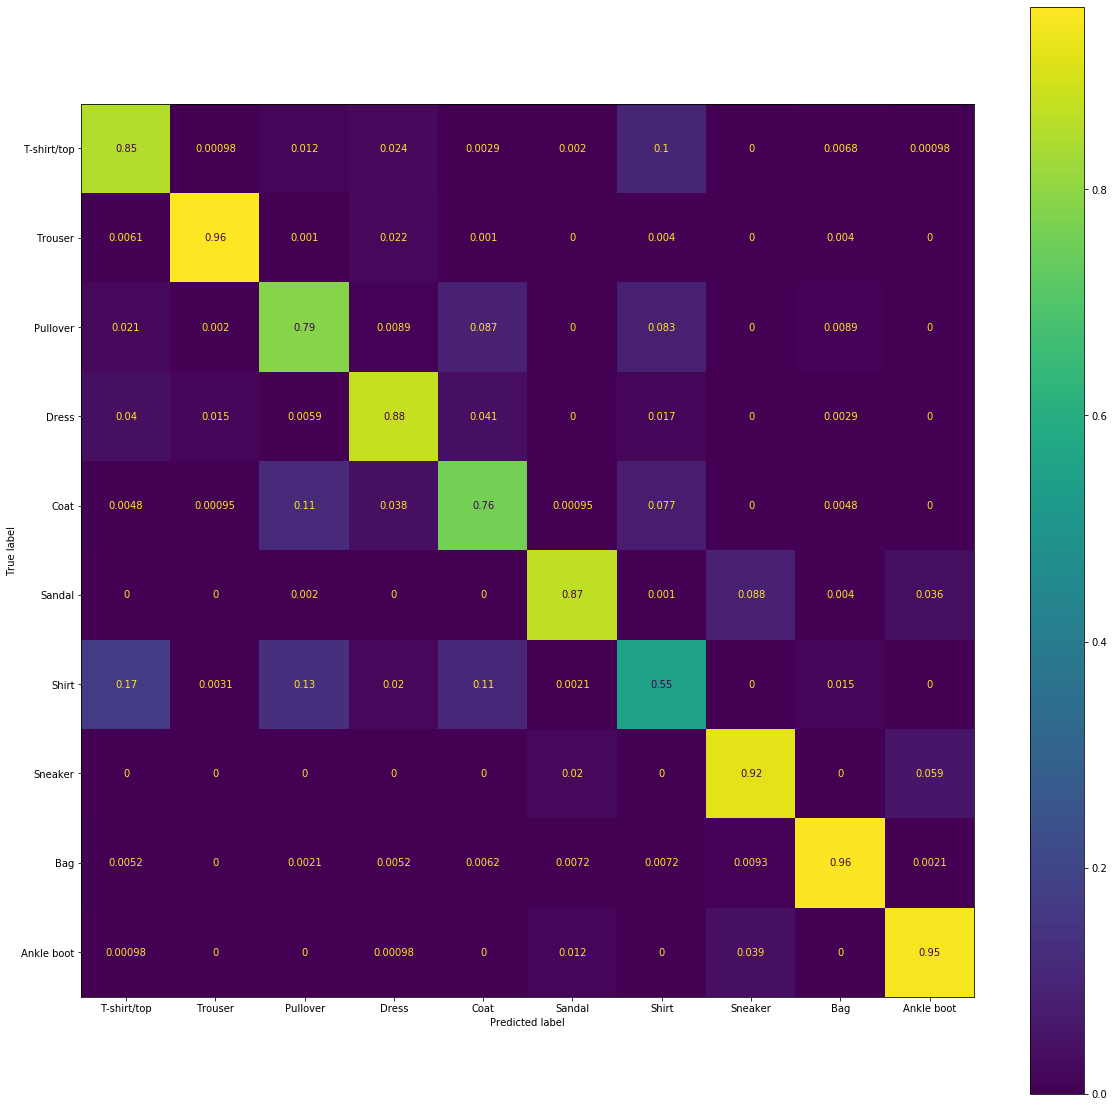

In [104]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(knn_5_pca, x_valid_pca, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP) 
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown labels in the test set: 

In [105]:
y_pred_knn=knn_5_pca.predict(x_test_pca)

In [106]:
# save that on a .csv file for the submission
predictions_knn_file=pd.DataFrame(y_pred_knn)
predictions_knn_file =predictions_knn_file.to_csv('data/y_predictions_5nn_pca.csv', sep=',',index=False)

# Model - Random Forest

### Pre-processing

In [108]:
x_train_scaled=x_train/255
x_valid_scaled=x_valid/255
x_test_scaled=x_test/255

pca = PCA(n_components=20, whiten=True, random_state=0).fit(x_train_scaled)
x_train_pca = pca.transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

### Model estimation
Using PCA, we reduced the features' dimension from 784 to 20. Now, we want to apply
a 'Decision Tree' to classify the items using only the 20 PCs extracted before.

Choosing the parameter 'max_depth' high enough, it's possible to classify 
perfectly each class in the training set, reaching an accuracy of 100%. But
then the performance in the test set is going to be much smaller, due to overfitting.

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Here we guess a value for 'max_depth', with the following result:

In [110]:
tree = DecisionTreeClassifier(max_depth=15,random_state=0)
tree.fit(x_train_pca, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(x_train_pca, y_train)))
print("Accuracy on validation set: {:.3f}".format(tree.score(x_valid_pca, y_valid)))

Accuracy on training set: 0.902
Accuracy on validation set: 0.783


To choose the optimal value of 'max_depth' it's needed a grid search. Anyway we don't investigate further the **Decision Tree** model, because we aim at a more robust result using an ensemble: **Random Forest**

A random forest is essentially a collection of decision trees, where each tree is slightly different from the others. The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount
of overfitting by averaging their results. 

**Important Note**: we are aware that, by using this kind of model over the features extracted via PCA, we are losing a very important advantage that Random Forest gives, which is the **interpretability** of the results (the principal components, are not features that we can interpret in a meaningful and intuitive way). Anyhow, we wanted to see how this kind of decision tree based model could perform on such a setting.

- 'n_estimators': number of trees to build (larger is always better. Averaging more trees will yield a more robust ensemble by reducing overfitting)
- 'max_features': number of randomly selected features among which the algo looks for the best one. It’s a good rule of thumb to use the default values: max_features=$\sqrt{n_{features}}$

In [ ]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=15,
                                max_features=5, 
                                random_state=0,
                                n_jobs=-1)
forest.fit(x_train_pca, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(x_train_pca, y_train)))
print("Accuracy on valid set: {:.3f}".format(forest.score(x_valid_pca, y_valid)))

We use the grid search technique to find the best values of hyperparameters:
- 'max_depth'
- 'max_features'

In [ ]:
# Define the grid for the grid search
param_grid = {'max_depth': list(range(1,21)),
              'max_features': list(range(1,21))}
# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
grid_search_forest = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                                  random_state=0,
                                                  n_jobs=-1),
                           param_grid, cv=cv,n_jobs=-1)
grid_search_forest.fit(x_train_pca, y_train)

The size of the full output file (.sav) is too big to be sent or uploaded, so we converted it in a Dataframe and then we saved it as a .csv file: 

In [117]:
#load the grid search results:
results_grid_search_forest=pd.read_csv('data/results_grid_search_forest.csv')
results_grid_search_forest.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_forest.head()

,params,mean_test_score,rank_test_score
385,"{'max_depth': 20, 'max_features': 6}",0.85472,1
383,"{'max_depth': 20, 'max_features': 4}",0.85458,2
365,"{'max_depth': 19, 'max_features': 6}",0.85424,3
389,"{'max_depth': 20, 'max_features': 10}",0.85410,4
366,"{'max_depth': 19, 'max_features': 7}",0.85394,5


There is a problem: the optimal hyperparamer 'max_depth' $=20$ is a corner solution.
To be sure that does not exist a better model with higher depth, we expand
the grid search to values of 'max_depth' $\ge20$.

<font color='orange'>
(**TO SAVE TIME, SKIP THE NEXT CELL AND LOAD THE TRAINED MODEL**) 

In [ ]:
param_grid = {'max_depth': list(range(20,30)),
              'max_features': list(range(5,11))}
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
grid_search_forest = GridSearchCV(RandomForestClassifier(n_estimators=100,
                                                  random_state=0,
                                                  n_jobs=-1),
                           param_grid, cv=cv,n_jobs=-1)
grid_search_forest.fit(x_train_pca, y_train)

In [124]:
#load the grid search results:
results_grid_search_restricted_forest=pd.read_csv('data/results_grid_search_restricted_forest.csv')
results_grid_search_restricted_forest.sort_values('rank_test_score',ascending=True, inplace=True)
results_grid_search_restricted_forest.head()

,params,mean_test_score,rank_test_score
26,"{'max_depth': 24, 'max_features': 7}",0.85596,1
43,"{'max_depth': 27, 'max_features': 6}",0.85588,2
25,"{'max_depth': 24, 'max_features': 6}",0.85578,3
38,"{'max_depth': 26, 'max_features': 7}",0.85562,4
19,"{'max_depth': 23, 'max_features': 6}",0.85560,5


In [ ]:
###The next 4 cells will be deleted when all models will have been converted in a csv

In [114]:
# save the model to disk
joblib.dump(knn_6, 'data/6nn.sav')

# to load the model from disk
#filename = 'grid_search_Logistic.sav'
grid_search_forest = joblib.load('data/grid_search_forest.sav')

In [ ]:
results_grid_search_restricted_forest = pd.DataFrame(grid_search_restricted_forest.cv_results_)
results_grid_search_restricted_forest=results_grid_search_restricted_forest[['params','mean_test_score','rank_test_score']]
results_grid_search_restricted_forest.head()

In [ ]:
knn_score=knn_6.score(x_valid_scaled, y_valid)
knn_score
knn_score_dict={'knn_score':[knn_score]}
knn_score_file=pd.DataFrame(knn_score_dict)
knn_score_file

In [123]:
#If the .sav file is too big to be shared with professor, we could save the dataFrame as a .csv
#and share only it.
results_grid_search_restricted_forest.to_csv('data/results_grid_search_restricted_forest.csv', sep=',',index=False)

#read the model
#pd.read_csv('data/results_grid_search_restricted_forest.csv')

We train the model with optimal hyperparameters:

In [125]:
forest = RandomForestClassifier(n_estimators=100,
                                max_depth=24,
                                max_features=7, 
                                random_state=0,
                                n_jobs=-1)
forest.fit(x_train_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=24, max_features=7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Model evaluation

In [127]:
# Use this function to evaluate your model
y_pred=forest.predict(x_valid_pca)
def accuracy(y_pred, y_true):
    '''
    input y_pred: ndarray of shape (N,)
    input y_true: ndarray of shape (N,)
    '''
    return (1.0 * (y_pred == y_true)).mean()

# Report the accuracy in the train and validation sets.
valid_set_accuracy=accuracy(y_pred,y_valid)
valid_set_accuracy

0.8508

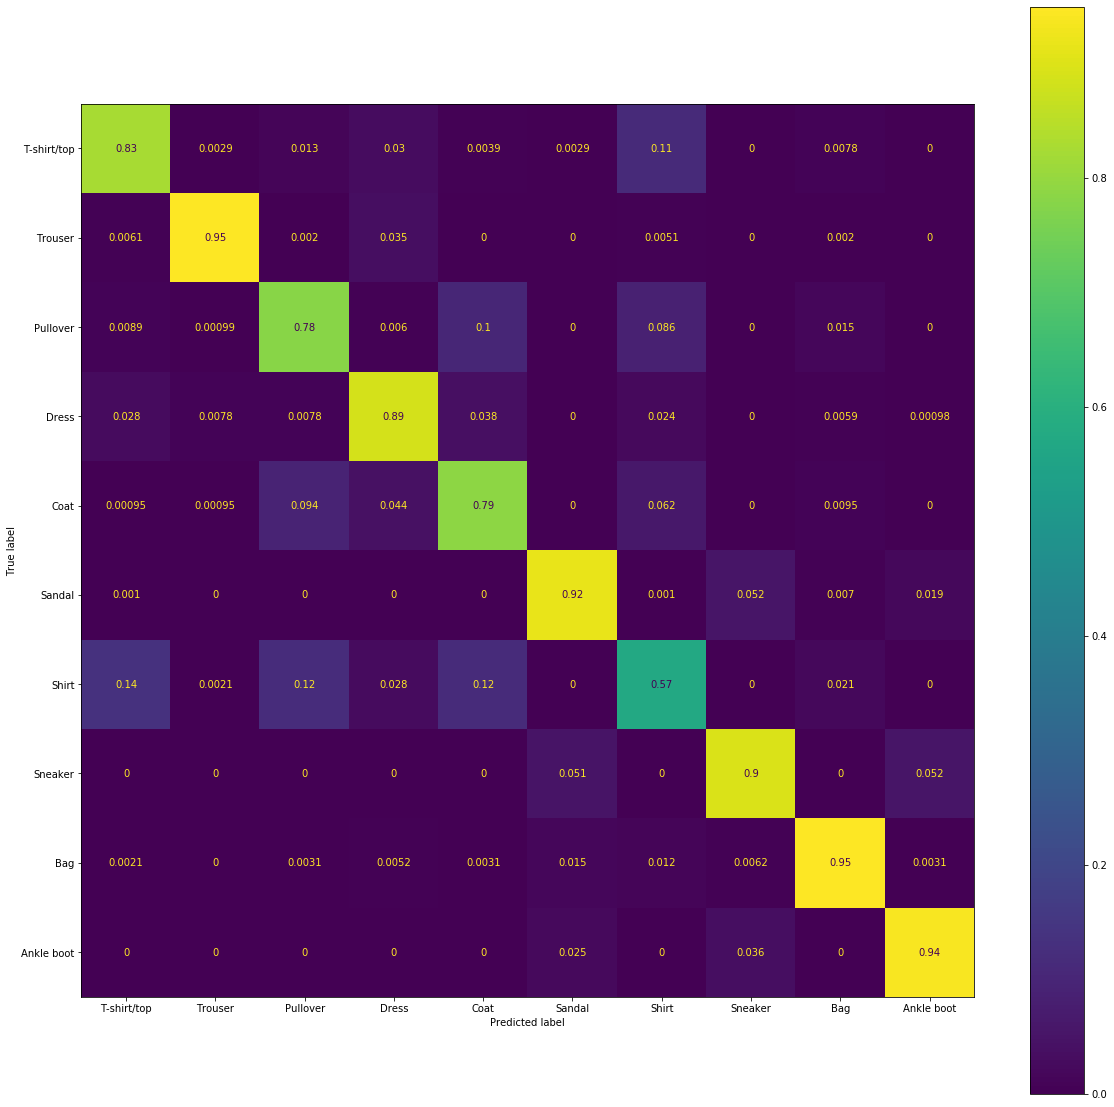

In [128]:
# confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
disp = metrics.plot_confusion_matrix(forest, x_valid_pca, y_valid,
                                     normalize='true',#row sums to 1 => Recall=TP/(TP+FN)
                                             #='pred',#column sums to 1 => Precision=TP/(TP+FP)  
                                     include_values=True,
                                     display_labels=y_labels,
                                     ax=ax)

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown labels in the test set: 

In [129]:
y_pred_forest=forest.predict(x_test_pca)

In [130]:
# save that on a .csv file for the submission
predictions_forest_file=pd.DataFrame(y_pred_forest)
predictions_forest_file =predictions_forest_file.to_csv('data/y_predictions_forest.csv', sep=',',index=False)

# Model - Neural Network

### Pre-processing

### Model estimation

### Model evaluation

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown label in the test set: 

In [ ]:
y_pred_nn=knn.predict(x_test)

# Model - Support Vector Machine

In [ ]:
from sklearn.svm import SVC

### Pre-processing

In [ ]:
#SET SIZE = size of training set to use. Use 50000 to use full TS
size = 10000

#For better numerical stability is advisible to divide by 255
x_train_sc=x_train[0:size]/255
x_valid_sc=x_valid[0:size]/255
x_test_sc =x_test[0:size]/255

y_train_sc=y_train[0:size]
y_valid_sc=y_valid[0:size]

### Model estimation

In [8]:
# Define the grid for the grid search
Cs = np.power(2, np.asarray(list(range(4)))).tolist() # C = regularization parameter
gammas = np.power(1/2, np.asarray(list(range(6)))).tolist()[3:] # gamma: parameter for the RBF kernel

param_grid = [
    {'C': Cs, 'gamma': gammas, 'kernel': ['rbf']},
]

# Cross Validation strategy
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
print(param_grid)

[{'C': [1, 2, 4, 8], 'gamma': [0.125, 0.0625, 0.03125], 'kernel': ['rbf']}]


In [15]:
##################################################
# Implement you model here
##################################################

svc = SVC()
# grid search con 5 fold cross validation
clf = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1)
clf.fit(x_train_sc, y_train)

print(clf.best_params_)
print("Cross Validation Accuracy: %f" % clf.best_score_)

{'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}
Cross Validation Accuracy: 0.872500


In [17]:
# save the model to disk
filename = 'grid_search_svm_downsampled.sav'
joblib.dump(clf, filename)

['grid_search_svm_downsampled.sav']

In [18]:
clf.best_params_

{'C': 4, 'gamma': 0.03125, 'kernel': 'rbf'}

In [19]:
clf.score(x_valid_sc, y_valid)

0.8781

In [23]:
results_svm_gs = pd.DataFrame(clf.cv_results_)
results_svm_gs.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,237.260946,1.239280,27.493530,0.134380,1,0.125,rbf,"{'C': 1, 'gamma': 0.125, 'kernel': 'rbf'}",0.748503,0.735265,0.741871,0.748374,0.766032,0.7480,0.010245,12
1,128.451676,1.635109,21.844860,0.238880,1,0.0625,rbf,"{'C': 1, 'gamma': 0.0625, 'kernel': 'rbf'}",0.856287,0.838661,0.861431,0.847924,0.864729,0.8538,0.009461,8
2,66.187876,0.774719,18.151979,0.261955,1,0.03125,rbf,"{'C': 1, 'gamma': 0.03125, 'kernel': 'rbf'}",0.866267,0.851648,0.874937,0.863432,0.877255,0.8667,0.009128,4
3,240.696215,0.314167,27.755970,0.341017,2,0.125,rbf,"{'C': 2, 'gamma': 0.125, 'kernel': 'rbf'}",0.761477,0.745255,0.757879,0.764882,0.779559,0.7618,0.011079,9
4,138.407228,0.680498,22.266635,0.117981,2,0.0625,rbf,"{'C': 2, 'gamma': 0.0625, 'kernel': 'rbf'}",0.865269,0.841159,0.868434,0.855928,0.870741,0.8603,0.010822,5


## Train a single model with the best params with all the TS

In [42]:
#load already trained model if available

In [37]:
svm_final = SVC(C=4, gamma=0.03125, kernel='rbf')
svm_final.fit(x_train_sc, y_train)

SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.03125, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Model evaluation

In [38]:
svm_final.score(x_valid_sc, y_valid)

0.9039

In [39]:
# save the model to disk
filename = 'svm_model_fullTS.sav'
joblib.dump(svm_final, filename)

['svm_model_fullTS.sav']

### Prediction on test set

Based on the model we have trained, these are our prediction for the unknown label in the test set: 

In [ ]:
y_pred_svm=svm_final.predict(x_test_sc)

In [ ]:
# save that on a .csv file for the submission
predictions_svm_file = y_pred_svm.to_csv('y_predictions_svm.csv', sep=',',index=False)